<a href="https://colab.research.google.com/github/hershcode/Springboard/blob/master/Capstone_2/Bitcoin_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import os 
os.chdir('/content/gdrive/My Drive')

In [0]:
from bitcoin_lib import *

import numpy
import math
from keras.models import Sequential 
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [0]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [0]:
def data_load(look_back):
  
  global scaler
  numpy.random.seed(7)
  training_data = prepared_data()[['open', 'volume_(btc)', 'rsi_15d', 'close']]
  close = training_data[['close']].copy()
  close.reset_index(drop=True, inplace=True)
  close = close.values
  close = close.astype('float32')
  scaler = MinMaxScaler(feature_range=(0, 1))
  close = scaler.fit_transform(close)
  train_size = int(len(close) * 0.80)
  test_size = len(close) - train_size
  train, test = close[0:train_size,:], close[train_size:len(close),:]
  xtrain, ytrain = create_dataset(train, look_back)
  xtest, ytest = create_dataset(test, look_back)
  xtrain = numpy.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
  xtest = numpy.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))
  
  return xtrain, ytrain, xtest, ytest, close

In [0]:
# create and fit the LSTM network
def initialize_model(block, look_back, optimizer, loss):
  model = Sequential()
  model.add(LSTM(block, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss=loss, optimizer=optimizer)
  
  return model

In [0]:
def fit_model(xtrain, ytrain, epochs, verbose):
  early_stopping_monitor = EarlyStopping(monitor='loss')
  model.fit(xtrain, ytrain, epochs=epochs, batch_size=1, verbose=verbose, callbacks=[early_stopping_monitor])
    
  return model

In [0]:
def predict(model, xtrain, xtest, ytrain, ytest):
  # make predictions
  trainPredict = model.predict(xtrain)
  testPredict = model.predict(xtest)
  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform([ytrain])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform([ytest])
  # calculate root mean squared error
  trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
  print('Train Score: %.2f MAE' % (trainScore))
  testScore = mean_absolute_error(testY[0], testPredict[:,0])
  print('Test Score: %.2f MAE' % (testScore))
  
  return trainPredict, testPredict

In [0]:
def plot_results(close, trainPredict, testPredict, look_black):
  
  plt.figure(figsize=(20,8))
  # shift train predictions for plotting
  trainPredictPlot = numpy.empty_like(close)
  trainPredictPlot[:, :] = numpy.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
  # shift test predictions for plotting
  testPredictPlot = numpy.empty_like(close)
  testPredictPlot[:, :] = numpy.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(close)-1, :] = testPredict
  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(close))
  plt.plot(trainPredictPlot)
  plt.plot(testPredictPlot)
  plt.legend(['close', 'training_prediction', 'test_prediction'])
  plt.show()

In [0]:
look_back=3

In [0]:
xtrain, ytrain, xtest, ytest, close = data_load(look_back=look_back)

In [0]:
xtrain

array([[[0.00045028, 0.00047082, 0.00057973]],

       [[0.00047082, 0.00057973, 0.00103843]],

       [[0.00057973, 0.00103843, 0.00097974]],

       ...,

       [[0.35503393, 0.3383908 , 0.3329198 ]],

       [[0.3383908 , 0.3329198 , 0.3452742 ]],

       [[0.3329198 , 0.3452742 , 0.35035598]]], dtype=float32)

In [0]:
model = initialize_model(block=3, look_back=look_back, optimizer='SGD', loss='mean_absolute_error')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 88
Trainable params: 88
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = fit_model(xtrain=xtrain, ytrain=ytrain, epochs=200, verbose=2)

W0627 07:20:43.428345 139908977579904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0627 07:20:43.898652 139908977579904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0627 07:20:43.923084 139908977579904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/200
 - 2s - loss: 0.0914
Epoch 2/200
 - 2s - loss: 0.0346
Epoch 3/200
 - 2s - loss: 0.0137
Epoch 4/200
 - 2s - loss: 0.0131
Epoch 5/200
 - 2s - loss: 0.0131
Epoch 6/200
 - 2s - loss: 0.0129
Epoch 7/200
 - 2s - loss: 0.0128
Epoch 8/200
 - 2s - loss: 0.0128
Epoch 9/200
 - 2s - loss: 0.0127
Epoch 10/200
 - 2s - loss: 0.0126
Epoch 11/200
 - 2s - loss: 0.0127


In [0]:
trainPredict, testPredict = predict(model=model, xtrain=xtrain, xtest=xtest, ytrain=ytrain, ytest=ytest)

Train Score: 152.34 MAE
Test Score: 197.48 MAE


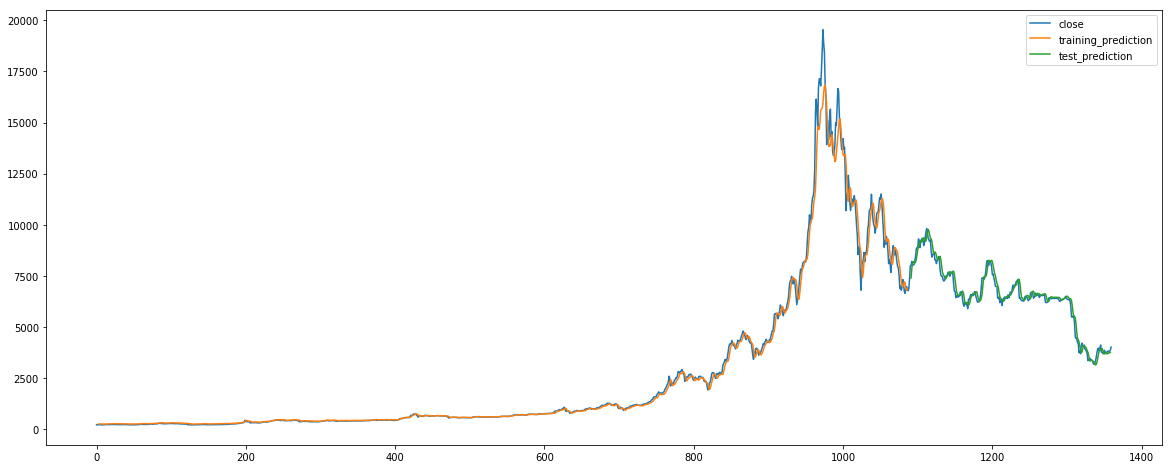

In [0]:
plot_results(close=close, trainPredict=trainPredict, testPredict=testPredict, look_black=look_back)

In [0]:
#### What percent of days is the model directionally correct?

In [0]:
#### 